In [1]:
import matplotlib.pyplot as plt
from sim_pipeline.gg_lens_pop import GGLensPop
%matplotlib inline

In [2]:
# define a cosmology
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define limits in the intrinsic deflector and source population (in addition to the skypy config file)
kwargs_lens_cut = {'mag_g_max':22, 'z_min': 0.1, 'z_max': 0.5}
kwargs_source_cut = {'mag_g_max':24, 'z_min': 1., 'z_max': 5.}

# run skypy pipeline and make galaxy-galaxy population class
gg_lens_pop = GGLensPop(lens_type='early-type', source_type='galaxies', 
                        kwargs_lens_cut=kwargs_lens_cut, kwargs_source_cut=kwargs_source_cut,
                        kwargs_mass2light=None, skypy_config=None, f_sky=0.1, cosmo=cosmo)


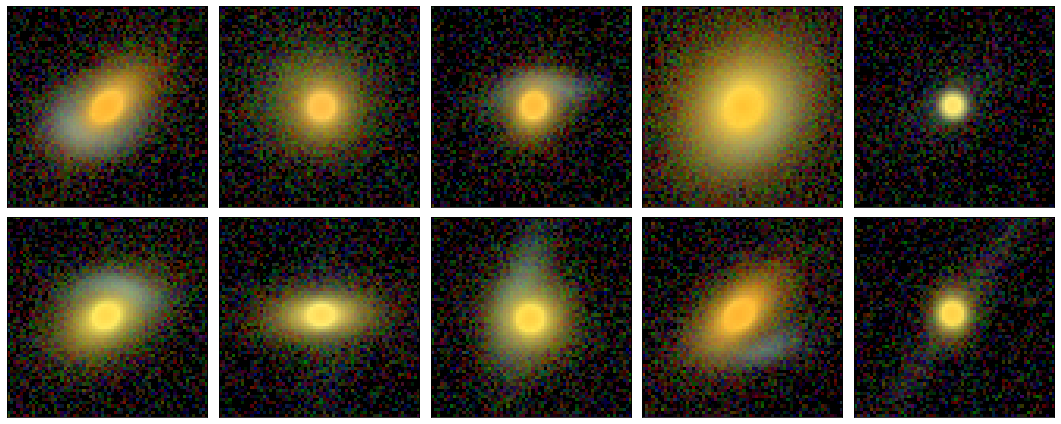

In [4]:
# make montage of realizations
from sim_pipeline.Plots.gg_plots import GGLensingPlots
gg_plot = GGLensingPlots(gg_lens_pop, num_pix=64, coadd_years=10)

fig, axes = gg_plot.plot_montage(rgb_band_list=['i', 'r', 'g'], add_noise=True, n_horizont=5, n_vertical=2)
plt.show()
